In [1]:
%load_ext lab_black
import os, sys

%load_ext autoreload
%autoreload 2

import matplotlib

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

import scdrs.util as util
import scdrs.data_loader as dl
import scdrs.method as md
import submitit
import os
import yaml
import os, sys
import pandas as pd

sys.path.append("/n/home12/khou/holystore/")
import paper_utils
import matplotlib.pyplot as plt
import numpy as np

In [2]:
DATA_PATH = "/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data"
data_facs_ct = dl.load_tms_ct(DATA_PATH, data_name="facs")
df_hom = pd.read_csv(
    "/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/gene_annotation/"
    "mouse_human_homologs.txt",
    sep="\t",
)

URL_SUPP_TABLE = "supp_tables.xlsx"

df_trait_info = pd.read_excel(
    URL_SUPP_TABLE,
    sheet_name=0,
)

df_celltype_info = pd.read_excel(
    URL_SUPP_TABLE,
    sheet_name=1,
)

/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.


In [3]:
list_gs_name = [
    f"{window_size}kb.{n_gene}"
    for window_size in [10]
    for n_gene in [100, 500, 1000, 2000]
] + [f"{window_size}kb.{n_gene}" for window_size in [0, 50] for n_gene in [1000]]

In [6]:
dict_df_fdr_prop = dict()
for gs_name in list_gs_name:
    dict_df_fdr_prop[gs_name] = pd.read_csv(
        f"data/summary_ct/drs_fdr_prop.{gs_name}.csv", index_col=0
    )
    df_fdr_prop = dict_df_fdr_prop[gs_name]
    df_plot = df_fdr_prop.loc[
        df_trait_info.Trait_Identifier.values, df_celltype_info.id.values
    ]
    fig, ax = paper_utils.plot_heatmap(
        df_plot,
        squaresize=20,
        heatmap_cbar_kws=dict(
            use_gridspec=False, location="top", fraction=0.03, pad=0.05, drawedges=True
        ),
        heatmap_vmin=0,
        heatmap_vmax=1,
        colormap_n_bin=10,
    )
    cb = ax.collections[0].colorbar
    cb.ax.set_title("Prop. of [FDR < 0.1]")
    cb.outline.set_edgecolor("black")
    cb.outline.set_linewidth(1)
    plt.title(gs_name)
    # do not show here as that make file size too large
    plt.close()

# Pattern

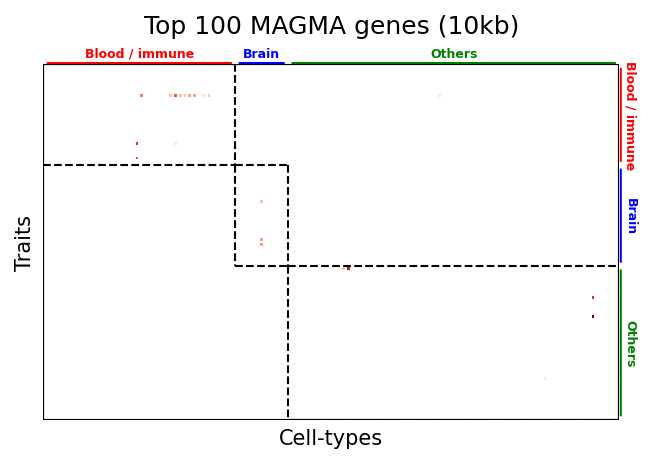

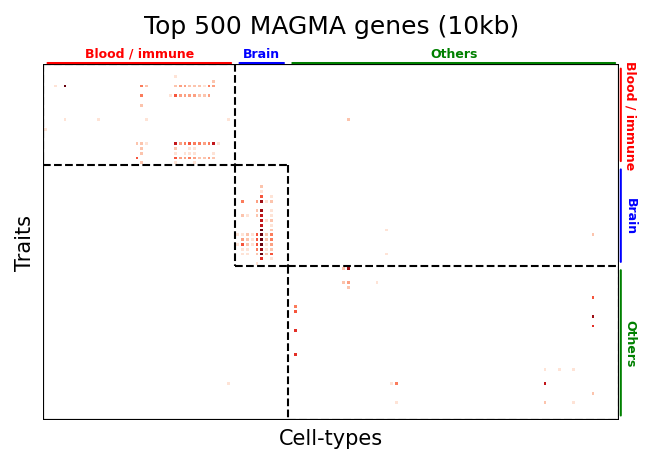

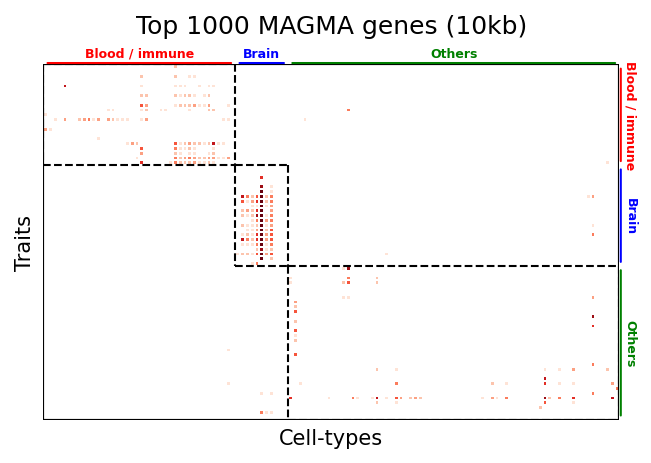

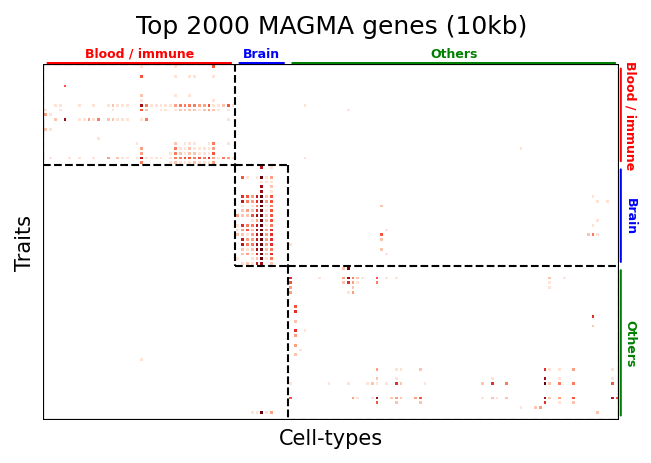

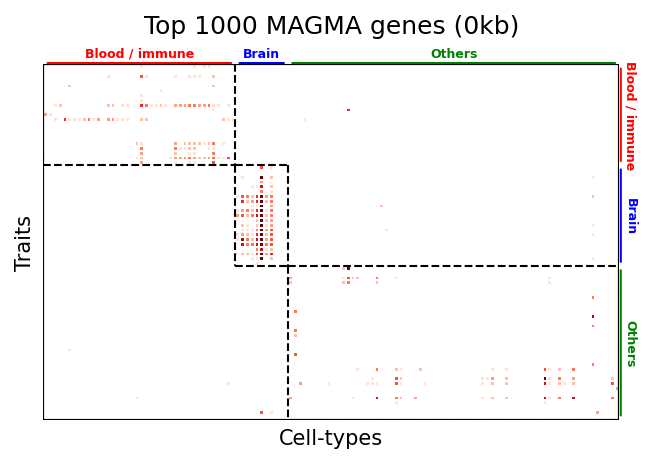

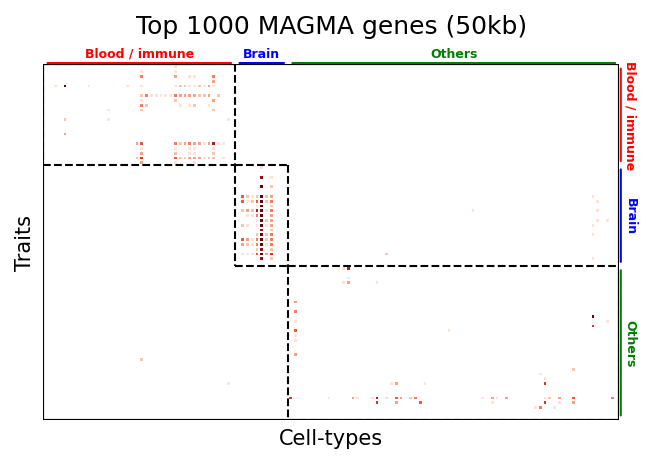

In [7]:
trait_orders, ct_orders = (
    df_trait_info.Trait_Identifier.values,
    df_celltype_info.id.values,
)

for gs_name in dict_df_fdr_prop:
    df_fdr_prop = dict_df_fdr_prop[gs_name]
    df_plot = df_fdr_prop.loc[trait_orders, ct_orders]
    fig, ax = paper_utils.plot_heatmap(
        df_plot,
        squaresize=5,
        heatmap_xticklabels=False,
        heatmap_yticklabels=False,
        heatmap_linecolor="white",
        heatmap_linewidths=0.1,
        heatmap_cbar_kws=dict(
            use_gridspec=False, location="top", fraction=0.03, pad=0.01, drawedges=True
        ),
        heatmap_vmin=0,
        heatmap_vmax=1,
        colormap_n_bin=10,
    )
    cb = ax.collections[0].colorbar
    cb.remove()
    #     cb.ax.set_title("Prop. of [FDR < 0.1]")
    #     cb.outline.set_edgecolor("black")
    #     cb.outline.set_linewidth(1)

    # add bounding box

    for x in ax.get_xlim():
        ax.axvline(x=x, color="k", linewidth=1)
        ax.axvline(x=x, color="k", linewidth=1)

    for y in ax.get_ylim():
        ax.axhline(y=y, color="k", linewidth=1)
        ax.axhline(y=y, color="k", linewidth=1)

    # add diagonal boxes

    x_seps = [
        df_trait_info.Category.isin(["blood/immune"]).sum(),
        df_trait_info.Category.isin(["brain"]).sum(),
        df_trait_info.Category.isin(["metabolic", "heart", "other"]).sum(),
    ]
    y_seps = [
        df_celltype_info.category.isin(["blood", "immune"]).sum(),
        df_celltype_info.category.isin(["brain"]).sum(),
        df_celltype_info.category.isin(["others"]).sum(),
    ]
    paper_utils.plot_diagonal_block(y_seps, x_seps, ax)
    window_size, n_gene = gs_name.split(".")
    plt.title(f"Top {n_gene} MAGMA genes ({window_size})", pad=15)
    plt.xlabel("Cell-types")
    plt.ylabel("Traits")

    dict_group_colors = {"Blood / immune": "r", "Brain": "b", "Others": "g"}
    # annotate cell-types
    ct_breaks = np.cumsum([0] + y_seps)
    for i, ct in enumerate(["Blood / immune", "Brain", "Others"]):
        paper_utils.annotation_line(
            ax=ax,
            text=ct,
            xy1=(ct_breaks[i], -0.3),
            xy2=(ct_breaks[i + 1], -0.3),
            text_offset_y=-2,
            linecolor=dict_group_colors[ct],
            text_color=dict_group_colors[ct],
            fontsize=6,
        )
        for label in ax.xaxis.get_ticklabels()[ct_breaks[i] : ct_breaks[i + 1]]:
            label.set_color(dict_group_colors[ct])

    # annotate traits
    trait_breaks = np.cumsum([0] + x_seps)
    for i, trait in enumerate(["Blood / immune", "Brain", "Others"]):

        paper_utils.annotation_line(
            ax=ax,
            text=trait,
            xy1=(ct_breaks[-1] + 0.3, trait_breaks[i]),
            xy2=(ct_breaks[-1] + 0.3, trait_breaks[i + 1]),
            text_rotation=270,
            text_offset_x=2,
            linecolor=dict_group_colors[trait],
            text_color=dict_group_colors[trait],
            fontsize=6,
        )
        for label in ax.yaxis.get_ticklabels()[trait_breaks[i] : trait_breaks[i + 1]]:
            label.set_color(dict_group_colors[trait])

    plt.savefig(f"results/geneset_robustness{gs_name}.pdf", bbox_inches="tight")
    plt.show()

In [8]:
from scipy.stats import pearsonr, spearmanr
from os.path import join

In [9]:
dict_score_df = dict()
for param in [
    "10kb.100",
    "10kb.500",
    "10kb.1000",
    "10kb.2000",
    "0kb.1000",
    "50kb.1000",
]:
    SCORE_PATH = f"00_calc_score/tms_facs/score_file/{param}/"
    dict_df = dict()
    for trait in df_trait_info["Trait_Identifier"].values:
        df_temp = pd.read_csv(
            join(SCORE_PATH, f"{trait}.score.gz"), sep="\t", index_col=0
        )
        dict_df[trait] = df_temp["zscore"]
    df_trs_zsc = pd.DataFrame(dict_df)
    dict_score_df[param] = df_trs_zsc

In [10]:
df_baseline = dict_score_df["10kb.1000"]

# correlation
dict_zsc_cor = {}
for gs_name in list_gs_name:
    list_cor = [
        pearsonr(df_baseline[trait], dict_score_df[gs_name][trait])[0]
        for trait in df_baseline
    ]
    dict_zsc_cor[gs_name] = list_cor

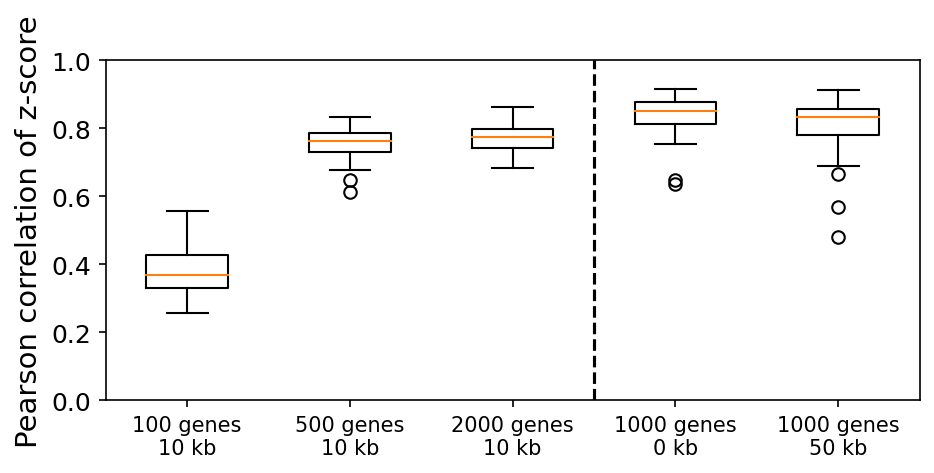

In [11]:
fig, ax = plt.subplots(figsize=(7, 3), dpi=150)
plt.boxplot(
    [dict_zsc_cor[gs_name] for gs_name in ["10kb.100", "10kb.500", "10kb.2000"]],
    positions=np.arange(1, 4),
    widths=0.5,
)

plt.boxplot(
    x=[dict_zsc_cor[gs_name] for gs_name in ["0kb.1000", "50kb.1000"]],
    positions=np.arange(4, 6),
    widths=0.5,
)
plt.ylim(0, 1)
plt.yticks(fontsize=12)
plt.ylabel("Pearson correlation of z-score", fontsize=14)

plt.xticks(
    ticks=np.arange(1, 6),
    labels=[
        "100 genes\n10 kb",
        "500 genes\n10 kb",
        "2000 genes\n10 kb",
        "1000 genes\n0 kb",
        "1000 genes\n50 kb",
    ],
    fontsize=10,
)
plt.axvline(x=3.5, ls="--", color="black")
plt.savefig("results/geneset_zsc_cor.pdf", bbox_inches="tight")
plt.show()

In [12]:
for param in dict_zsc_cor:
    print(
        param,
        f": {np.mean(dict_zsc_cor[param]):.2f} ({np.std(dict_zsc_cor[param]):.2f})",
    )

10kb.100 : 0.38 (0.06)
10kb.500 : 0.76 (0.04)
10kb.1000 : 1.00 (0.00)
10kb.2000 : 0.77 (0.04)
0kb.1000 : 0.84 (0.05)
50kb.1000 : 0.81 (0.07)
